In [ ]:
"""
Overall algorithm for prediction 5

build feature vectors for all images
compute kernels
combine kernels (almost always product)

for 25 trials:
    get train/test datasets
    Resample samples to make distribution of hit rates uniform ???
    select training set split half kernels (for grid search on hyperparameters)  
    for 4 grid_search_trials:
        build dataset
    
    test 7x7 combinations of 2 hyper params (on 4 grid_search_trials)
    select best hyper params
    
    train/test for real
"""

## Imports

In [75]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import mat4py
import scipy.io
import numpy as np
import math
from sklearn.svm import SVR
from sklearn.preprocessing import normalize
import os
from pykernels.regular import Min
from tqdm import tqdm
from scipy.stats.stats import spearmanr
from fit_predict_sk import compute_kernel

print('open cv version:', cv2.__version__)

FileNotFoundError: [Errno 2] No such file or directory: 'input/Data/Random splits/image_test_indices.mat'

## Load data

In [17]:
base_path = '../matlab/data/'

# splits
mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/image_test_indices.mat'))
image_test_indices = mat['image_test_indices']
print(image_test_indices.shape)

mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/image_train_indices.mat'))
image_train_indices = mat['image_train_indices']
print(image_train_indices.shape)

mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/subject_hrs1.mat'))
subject_hrs1 = mat['subject_hrs1']
print(subject_hrs1.shape)

mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/subject_hrs2.mat'))
subject_hrs2 = mat['subject_hrs2']
print(subject_hrs2.shape)

# for grid search
mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/T1_train_indices.mat'))
T1_train_indices = mat['T1_train_indices']
print(T1_train_indices.shape)

mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/T2_train_indices.mat'))
T2_train_indices = mat['T2_train_indices']
print(T2_train_indices.shape)

mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/T1_train_subject_hrs.mat'))
T1_train_subject_hrs = mat['T1_train_subject_hrs']
print(T1_train_subject_hrs.shape)

mat = scipy.io.loadmat(os.path.join(base_path, 'Random splits/T2_train_subject_hrs.mat'))
T2_train_subject_hrs = mat['T2_train_subject_hrs']
print(T2_train_subject_hrs.shape)

target_features = scipy.io.loadmat(os.path.join(base_path,'Image data/target_features.mat'))

print('All LOADED')

(25, 1111)
(25, 1111)
(25, 2222)
(25, 2222)
(25, 25, 556)
(25, 25, 555)
(25, 2222)
(25, 2222)
All LOADED


## Object counts (without semantics)

In [5]:
# counts = target_features['Counts'].todense().T
# imgs_num = counts.shape[0]
# max_count = np.max(counts)
# steps = 22
# step_size = max_count / steps
# bins = np.linspace(0.0, max_count, steps)

# # marginalize
# object_count_features = np.empty((imgs_num, steps-1))
# for i in range(imgs_num):
#     object_counts_img = counts[i,:]
#     hist, _ = np.histogram(object_counts_img, bins=bins)
#     object_count_features[i, :] = hist
    
# # normalize
# X = normalize(object_count_features, norm='l1')
# X_kernel = compute_kernel(X, X)
# fit_predict_sk(X_kernel)


counts = target_features['Counts'].todense().T
imgs_num = counts.shape[0]
max_count = np.max(counts)
steps = 20
step_size = max_count / steps
bins = np.linspace(0.0, max_count, steps)

# marginalize

# hist function in matlab defines the bins as bin centers
# https://www.mathworks.com/help/matlab/ref/hist.html
# therefore, here we need to try to mimic this behavior
step_size = round(max_count / steps, 4)
bin_centers = np.arange(0, max_count + 2 * step_size, step_size)
bins_edges = bin_centers - step_size / 2

# marginalize
object_count_features = np.empty((imgs_num, len(bins_edges) - 1))
for i in range(imgs_num):
    hist, _ = np.histogram(counts[i, :], bins=bins_edges)
    object_count_features[i, :] = hist

# normalize
X = normalize(object_count_features, norm='l1')
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [00:35<00:00,  1.39s/it]

top 20: 0.6772244655894856
top 100: 0.6823562195070635
bottom 100: 0.6810663155450019
bottom 20: 0.6849669578879201
corr avg: 0.032188259207503685


## Areas (without semantics)

In [35]:
areas = target_features['Areas'].todense()
areas = areas.T
imgs_num = areas.shape[0]
max_count = np.max(areas)
steps = 602
step_size = max_count / steps
bins = np.linspace(0.0, max_count, steps)

# marginalize
X = np.empty((imgs_num, steps-1))
for i in range(imgs_num):
    X[i, :], _ = np.histogram(areas[i,:], bins=bins)
    
# normalize
X = normalize(X, norm='l1')
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)
# fit_predict2(X)


  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

top 20: 0.682013778408739
top 100: 0.6872644179320401
bottom 100: 0.6370800134132496
bottom 20: 0.6352735635059396
corr avg: 0.05701747739453637


## Multiscale Object Areas (unlabeled)

In [62]:
sptHistObjects = target_features['sptHistObjects']
areas = target_features['Areas'].todense()
num_objects = areas.shape[0];
num_spt_hists = int(sptHistObjects.shape[1]/num_objects);
imgs_num = sptHistObjects.shape[0]
num_steps = 20;

m_xs = None

# num_spt_hists is equal to 5 (6800 / 1360 = 5)
# each loop here is a quadrant (why 5 and not 4??)
for j in range(0, num_spt_hists):
    x = x0[:,(num_objects*j):(num_objects*(j+1))];
    max_area = np.max(x);
    
    # hist function in matlab defines the bins as bin centers
    # https://www.mathworks.com/help/matlab/ref/hist.html
    # therefore, here we need to try to mimic this behavior
    step_size = round(max_area / num_steps, 4)
    
    bin_centers = np.arange(0, max_area + 2*step_size, step_size)
    bins_edges = bin_centers - step_size/2
    
#     print('bin edges:', bins_edges)
    
    # marginalize
    m_x = np.empty((imgs_num, len(bins_edges)-1))
    for i in range(imgs_num):
        m_x[i, :], _ = np.histogram(x[i,:], bins=bins_edges)

    if m_xs is None:
        m_xs = m_x
    else:
        m_xs = np.hstack((m_xs, m_x))

# normalize m_xs
X = m_xs # this is (2400, 105)

X = normalize(X, norm='l1')
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

top 20: 0.730085418448756
top 100: 0.7269481424279165
bottom 100: 0.6393692377767888
bottom 20: 0.6454176752872652
corr avg: 0.18860128230260198


## Object labels presences

In [34]:
X = target_features['Counts'].todense().T
X = X > 0
    
# normalize
X = normalize(X, norm='l1')
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [01:07<00:00,  2.65s/it]

top 20: 0.8332503201500772
top 100: 0.7977146458178046
bottom 100: 0.5696507962988834
bottom 20: 0.5402373306154177
corr avg: 0.43098610670410215


## Labeled Object Counts

In [33]:
X = target_features['Counts'].todense().T

# normalize
X = normalize(X, norm='l1')
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [01:00<00:00,  2.44s/it]

top 20: 0.8208632420887234
top 100: 0.790059128188836
bottom 100: 0.5690418367938676
bottom 20: 0.549044016290458
corr avg: 0.43692896769316714


## Labeled Object Areas

In [32]:
X = target_features['Areas'].todense().T

# normalize
X = normalize(X, norm='l1') 
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)


  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [01:00<00:00,  2.28s/it]

top 20: 0.8410899971668345
top 100: 0.8195147604503974
bottom 100: 0.5652826913554956
bottom 20: 0.5307101031452471
corr avg: 0.4774915805443873


## Labeled Multiscale Object Areas

In [6]:
X = target_features['sptHistObjects']
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [00:50<00:00,  1.95s/it]

top 20: 0.8438429665549126
top 100: 0.8213395740809214
bottom 100: 0.5618808313568993
bottom 20: 0.5258719195176088
corr avg: 0.47937855895059556


## Scene Category

In [31]:
X = target_features['sceneCatFeatures']

# normalize
X = normalize(X, norm='l1') 
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edgartanaka/miniconda3/envs/mo446/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 25/25 [00:49<00:00,  2.03s/it]

top 20: 0.8132759293668118
top 100: 0.7732187390320355
bottom 100: 0.5772078505840779
bottom 20: 0.5596950147667348
corr avg: 0.3609991504586699


## Objects and Scenes

In [81]:
X1 = target_features['sptHistObjects']
X2 = target_features['sceneCatFeatures']
X2 = normalize(X2, norm='l1') 
X = np.hstack((X1, X2))
X_kernel = compute_kernel(X, X)
fit_predict_sk(X_kernel)


  4%|▍         | 1/25 [00:01<00:47,  1.97s/it]

best hyper params are: 0.6934815942243997 0.01 0.1


  8%|▊         | 2/25 [00:03<00:44,  1.94s/it]

best hyper params are: 0.7124886588290373 0.01 0.01


 12%|█▏        | 3/25 [00:05<00:42,  1.92s/it]

best hyper params are: 0.7074823156785822 0.01 0.1


 16%|█▌        | 4/25 [00:07<00:40,  1.94s/it]

best hyper params are: 0.69829578744839 0.1 0.1


 20%|██        | 5/25 [00:09<00:39,  2.00s/it]

best hyper params are: 0.6833340817156895 0.01 0.0001


 24%|██▍       | 6/25 [00:11<00:37,  1.97s/it]

best hyper params are: 0.688341634049849 0.01 0.001


 28%|██▊       | 7/25 [00:13<00:35,  1.95s/it]

best hyper params are: 0.6907867734291426 0.01 0.01


 32%|███▏      | 8/25 [00:16<00:35,  2.08s/it]

best hyper params are: 0.7197658258515528 0.1 0.1


 36%|███▌      | 9/25 [00:18<00:33,  2.10s/it]

best hyper params are: 0.6972822918586542 0.01 0.01


 40%|████      | 10/25 [00:20<00:30,  2.03s/it]

best hyper params are: 0.7051687249936862 0.01 0.1


 44%|████▍     | 11/25 [00:22<00:28,  2.03s/it]

best hyper params are: 0.6892690800285595 0.01 0.1


 48%|████▊     | 12/25 [00:24<00:26,  2.03s/it]

best hyper params are: 0.681702319740759 0.01 0.0001


 52%|█████▏    | 13/25 [00:26<00:24,  2.07s/it]

best hyper params are: 0.699186723857915 0.01 0.01


 56%|█████▌    | 14/25 [00:28<00:22,  2.07s/it]

best hyper params are: 0.6989199957795497 0.01 0.1


 60%|██████    | 15/25 [00:30<00:20,  2.04s/it]

best hyper params are: 0.716883091419553 0.1 0.1


 64%|██████▍   | 16/25 [00:32<00:18,  2.00s/it]

best hyper params are: 0.7056495833363039 0.01 0.0001


 68%|██████▊   | 17/25 [00:34<00:15,  2.00s/it]

best hyper params are: 0.7008876371935042 0.01 0.001


 72%|███████▏  | 18/25 [00:36<00:14,  2.01s/it]

best hyper params are: 0.7115623731525276 0.01 0.0001


 76%|███████▌  | 19/25 [00:38<00:12,  2.02s/it]

best hyper params are: 0.6915011747893862 0.01 0.01


 80%|████████  | 20/25 [00:40<00:09,  1.98s/it]

best hyper params are: 0.6839294868212856 0.1 0.1


 84%|████████▍ | 21/25 [00:42<00:07,  1.99s/it]

best hyper params are: 0.7121321618768794 0.1 0.01


 88%|████████▊ | 22/25 [00:44<00:05,  1.94s/it]

best hyper params are: 0.721911726114441 0.01 0.01


 92%|█████████▏| 23/25 [00:46<00:03,  1.96s/it]

best hyper params are: 0.6873828750449992 0.01 0.1


 96%|█████████▌| 24/25 [00:47<00:01,  1.94s/it]

best hyper params are: 0.7106037373096797 0.01 0.0001


100%|██████████| 25/25 [00:49<00:00,  1.95s/it]

best hyper params are: 0.7108565700739353 0.01 0.01
top 20: 0.845250890463498
top 100: 0.8233356461175048
bottom 100: 0.5528030454432781
bottom 20: 0.5167845492999491
corr avg: 0.5034583812667964


##  OpenCV

In [10]:
# grid search of SVR hyper params
best_c = -1
best_p = -1

def try_params_cv(features, split_idx, c, p):
    '''
    Tries this combination of c and p and returns the mean
    of the R coefficient.
    
    features must be (2400, N_feats)
    split_idx: splits from 1 to 25
    '''
    T1_train_labels_all = T1_train_subject_hrs[split_idx,:]
    T2_train_labels_all = T2_train_subject_hrs[split_idx,:]

    # build the grid search 4 different splits
    all_rs = []
    for i in range(4):
        train_idx = np.ravel(T1_train_indices[split_idx,i,:]) - 1 # 1-based index
        test_idx = np.ravel(T2_train_indices[split_idx,i,:]) - 1

        X_train = features[train_idx, :]
        X_test = features[test_idx, :]        
        y_train = T1_train_labels_all[train_idx]
        y_test = T2_train_labels_all[test_idx]
        
        # opencv demands type float32 for train/test
        X_train = X_train.astype(np.float32)
        y_train = y_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        y_test = y_test.astype(np.float32)
        
        # epsilon SVR with histogram intersection kernel 
        svm = cv2.ml.SVM_create()
        svm.setKernel(cv2.ml.SVM_INTER)
        svm.setType(cv2.ml.SVM_EPS_SVR)
        svm.setC(c)
        svm.setP(p)
        svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
        predicted_memo_scores = np.ravel(svm.predict(X_test)[1])
        
        r = np.corrcoef(predicted_memo_scores, y_test)
        all_rs.append(r)
        
    return np.mean(all_rs)
        

def run_grid_cv(features, split_idx):
    '''
    Grid search for hyperparams c and p of SVR.
    Finds the best c and p based on squared correlation coefficient.
    For each pair of c and p, tries 4 splits, averages the squared correlation coefficient on all.
    Returns the best pair c and p with highest mean squared correlation coefficient.
    '''
    # return the best c and p
    best_r = -1
    best_c = 0.01
    best_p = 0.01
    for i in range(1,7):
        for j in range(1,7):
            p = 10**(i-5)
            c = 10**(j-5)
#             mean_r = try_params(features, split_idx, c, p)
            try:
                mean_r = try_params(features, split_idx, c, p)
                if mean_r > best_r:
                    best_r = mean_r
                    best_c = c
                    best_p = p
            except Exception as e:
                print('exception for hyperparams:', c, p)
                pass

    return best_r, best_c, best_p

def fit_predict_cv(features):
    # features must be (2400, N_feats)
    splits = 25
            
    # train and test for real now
    top_20_scores = []
    top_100_scores = []
    bottom_100_scores = []
    bottom_20 = []
    
    for i in range(splits):
        best_r, best_c, best_p = run_grid_cv(features, i)
        
        train_idx = image_train_indices[i, :] - 1 # -1 because .mat is 1-based index
        test_idx = image_test_indices[i, :] - 1
        X_train = features[train_idx, :]
        X_test = features[test_idx, :]    
        y_train = subject_hrs1[i, train_idx]
        y_test = subject_hrs2[i, test_idx]

        # opencv demands type float32 for train/test
        X_train = X_train.astype(np.float32)
        y_train = y_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        y_test = y_test.astype(np.float32)
        
        # epsilon SVR with histogram intersection kernel 
        svm = cv2.ml.SVM_create()
        svm.setKernel(cv2.ml.SVM_INTER)
        svm.setType(cv2.ml.SVM_EPS_SVR)
        svm.setC(best_c)
        svm.setP(best_p)
        svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
        _, predicted_memo_scores = svm.predict(X_test)
        
        # get indices of sorted memo scores
        idx = np.argsort(np.ravel(predicted_memo_scores))
        
        # order y_test according to the scores predicted
        empirical_memo_scores = y_test[idx]
        
        top_20_scores.append(empirical_memo_scores[-20:])
        top_100_scores.append(empirical_memo_scores[-100:])
        bottom_100_scores.append(empirical_memo_scores[0:100])
        bottom_20.append(empirical_memo_scores[0:20])

    print('top 20:', np.sum(top_20_scores)/(splits*20))
    print('top 100:', np.sum(top_100_scores)/(splits*100))
    print('bottom 100:', np.sum(bottom_100_scores)/(splits*100))
    print('bottom 20:', np.sum(bottom_20)/(splits*20))


##  SKlearn

In [80]:
# grid search of SVR hyper params

def compute_kernel(data_1, data_2):
    if np.any(data_1 < 0) or np.any(data_2 < 0):
        warnings.warn('Min kernel requires data to be strictly positive!')

    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

def try_params_sk(features_kernel, split_idx, c, p):
    '''    
    features_kernel must be (2400, 2400)
    split_idx: splits from 1 to 25
    '''
    T1_train_labels_all = T1_train_subject_hrs[split_idx,:]
    T2_train_labels_all = T2_train_subject_hrs[split_idx,:]

    # build the grid search 4 different splits
    all_rs = []
    for i in range(4):        
        train_idx = np.ravel(T1_train_indices[split_idx,i,:]) - 1 # 1-based index
        test_idx = np.ravel(T2_train_indices[split_idx,i,:]) - 1

        X_train = features_kernel[train_idx[:, None], train_idx] 
        X_test = features_kernel[test_idx[:, None], train_idx]
        y_train = T1_train_labels_all[train_idx]
        y_test = T2_train_labels_all[test_idx]
        
        # opencv demands type float32 for train/test
        X_train = X_train.astype(np.float32)
        y_train = y_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        y_test = y_test.astype(np.float32)
        
        # epsilon SVR with histogram intersection kernel 
        svr = SVR(kernel='precomputed', C=c, epsilon=p)
        predicted_memo_scores = svr.fit(X_train, y_train).predict(X_test)
    
        # measure squared correlation coefficient between predicted and ground truth
        r = np.corrcoef(predicted_memo_scores, y_test)
        all_rs.append(r)
        
    return np.mean(all_rs)
        

def run_grid_sk(features, split_idx):
    '''
    Grid search for hyperparams c and p of SVR.
    Finds the best c and p based on squared correlation coefficient.
    For each pair of c and p, tries 4 splits, averages the squared correlation coefficient on all.
    Returns the best pair c and p with highest mean squared correlation coefficient.
    '''
    # return the best c and p
    best_r = -1
    best_c = 0.01
    best_p = 0.01
    for i in range(1,7):
        for j in range(1,7):
            p = 10**(i-5)
            c = 10**(j-5)
            mean_r = try_params_sk(features, split_idx, c, p)
            if mean_r > best_r:
                best_r = mean_r
                best_c = c
                best_p = p


    return best_r, best_c, best_p

def fit_predict_sk(features_kernel):
    # features_kernel must be (2400, 2400)
    splits = 25

    # train and test for real now
    top_20_scores = []
    top_100_scores = []
    bottom_100_scores = []
    bottom_20 = []
    corrs = []

    for i in tqdm(range(splits)):
        best_r, best_c, best_p = run_grid_sk(features_kernel, i)
        print('best hyper params are:', best_r, best_c, best_p)
        
        train_idx = image_train_indices[i, :] - 1
        test_idx = image_test_indices[i, :] - 1
        X_train = features_kernel[train_idx[:, None], train_idx] 
        X_test = features_kernel[test_idx[:, None], train_idx]  
        y_train = subject_hrs1[i, train_idx]
        y_test = subject_hrs2[i, test_idx]

        # epsilon SVR with histogram intersection kernel 
        svr = SVR(kernel='precomputed', C=best_c, epsilon=best_p)
        predicted_memo_scores = svr.fit(X_train, y_train).predict(X_test)
        
        # get indices of sorted memo scores
        idx = np.argsort(predicted_memo_scores)

        # rank the test measurements according to predictions
        empirical_memo_scores = y_test[idx]

        # calculate the measured memorability scores according to the ranking
        top_20_scores.append(empirical_memo_scores[-20:])
        top_100_scores.append(empirical_memo_scores[-100:])
        bottom_100_scores.append(empirical_memo_scores[0:100])
        bottom_20.append(empirical_memo_scores[0:20])
        
        # calculate spearman rank correlation
        rho, _ = spearmanr(predicted_memo_scores, y_test)
        corrs.append(rho)

    print('top 20:', np.sum(top_20_scores)/(25*20))
    print('top 100:', np.sum(top_100_scores)/(25*100))
    print('bottom 100:', np.sum(bottom_100_scores)/(25*100))
    print('bottom 20:', np.sum(bottom_20)/(25*20))
    print('corr avg:', np.mean(corrs))
    

## Reproducing Figure 1

Avg score for least memorable pics: 0.24300496793403767
Avg score for typical memorable pics: 0.6875840053763441
Avg score for most memorable pics: 0.9595759409159826


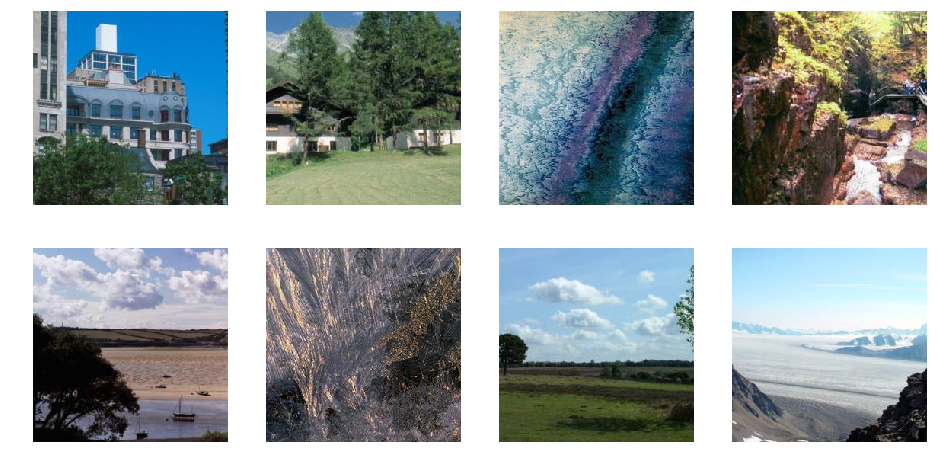

<Figure size 432x288 with 0 Axes>

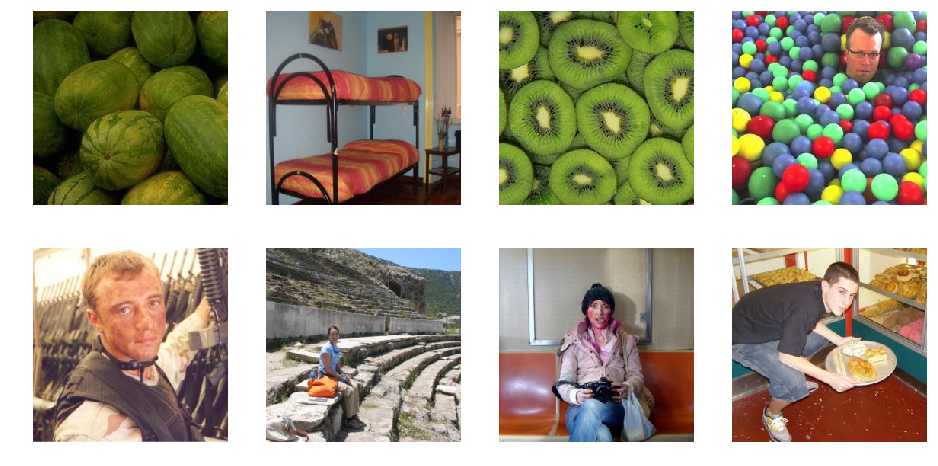

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [71]:
base_path = '../matlab/data/'
# target_images = scipy.io.loadmat(os.path.join(base_path,'Image data/target_images.mat'))
all_images = target_images['img']

def plot(indexes):
    # plotting
    w=10
    h=10
    fig=plt.figure(figsize=(16, 8))
    columns = 4
    rows = 2    
    
    # print least memorable images
    for pos, i in enumerate(indexes):
        fig.add_subplot(rows, columns, pos+1)
        plt.axis('off')
        plt.imshow(get_image(i))
        
    plt.show()
    plt.clf()


def get_image(idx):
    img = all_images[:,:,:,idx]
    return img
    
# get_image(3)
df = mat4py.loadmat(os.path.join(base_path,'Experiment data/sorted_target_data.mat'))
features_list = [x[0] for x in df['sorted_target_data']]
df = pd.DataFrame.from_dict(features_list)

df['score'] = df['hits']/(df['hits']+df['misses'])
sorted_images_idx = df.sort_values(by=['score']).index.values
sorted_scores = df.sort_values(by=['score'])

# calculating average scores in 3 tiers
least_memo_avg_score = sorted_scores['score'][0:8].mean()
print('Avg score for least memorable pics:', least_memo_avg_score)
typical_memo_avg_score = sorted_scores['score'][1236:1244].mean()
print('Avg score for typical memorable pics:', typical_memo_avg_score)
most_memo_avg_score = sorted_scores['score'][-8:].mean()
print('Avg score for most memorable pics:', most_memo_avg_score)

# getting indexes for most, least, avg memorable images
least = sorted_images_idx[0:8]
most = sorted_images_idx[-8:]
average = sorted_images_idx[1236:1244]

plot(least)
plot(most)
plot(average)




## Getting samples of predicted images by tier

[0.68516294 0.67383195 0.70291139 ... 0.63904086 0.88758058 0.56350434]
Avg score for least memorable pics: 0.4428988738913293
Avg score for typical memorable pics: 0.6739389385782446
Avg score for most memorable pics: 0.9205496333411809


<Figure size 432x288 with 0 Axes>

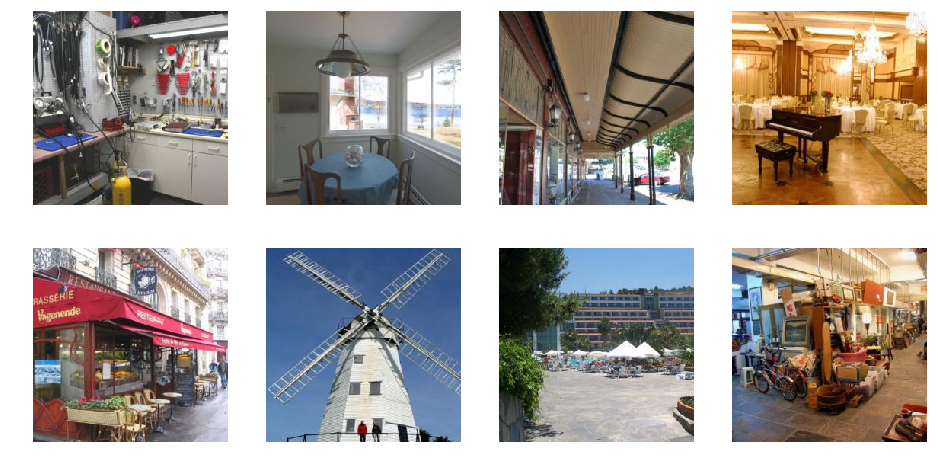

<Figure size 432x288 with 0 Axes>

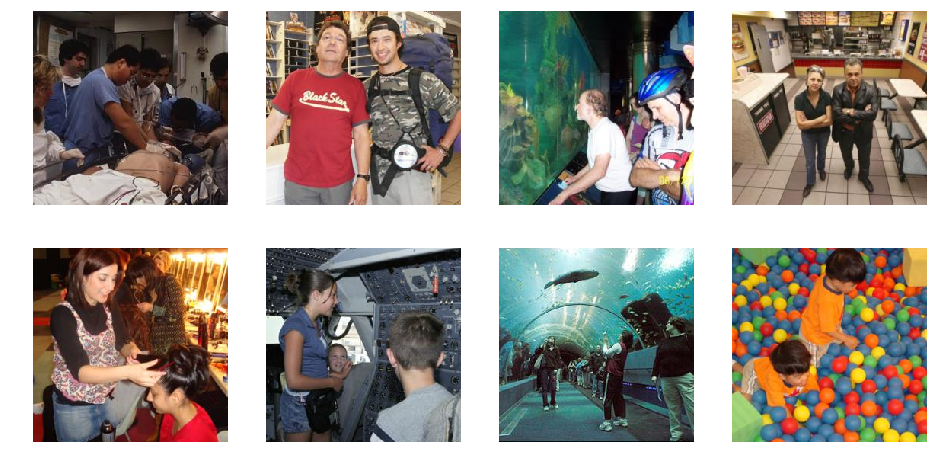

<Figure size 432x288 with 0 Axes>

In [113]:
import pickle
import sklearn

def try_params_sk(features_kernel, train_idx, c, p):
    # build the grid search 4 different splits
    all_rs = []
    T1_train_labels_all = subject_hrs1[0]
    
    for i in range(4):
        train_idx, valid_idx = sklearn.model_selection.train_test_split(train_idx, test_size=int(1111*0.2))
        
        X_train = features_kernel[train_idx[:, None], train_idx] 
        X_test = features_kernel[valid_idx[:, None], train_idx]
        y_train = T1_train_labels_all[train_idx]
        y_test = T1_train_labels_all[valid_idx]
        
        # opencv demands type float32 for train/test
        X_train = X_train.astype(np.float32)
        y_train = y_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        y_test = y_test.astype(np.float32)
        
        # epsilon SVR with histogram intersection kernel 
        svr = SVR(kernel='precomputed', C=c, epsilon=p)
        predicted_memo_scores = svr.fit(X_train, y_train).predict(X_test)
    
        # measure squared correlation coefficient between predicted and ground truth
        r = np.corrcoef(predicted_memo_scores, y_test)
        all_rs.append(r)
        
    return np.mean(all_rs)

def run_grid_sk(features, train):
    '''
    Grid search for hyperparams c and p of SVR.
    Finds the best c and p based on squared correlation coefficient.
    For each pair of c and p, tries 4 splits, averages the squared correlation coefficient on all.
    Returns the best pair c and p with highest mean squared correlation coefficient.
    '''
    # return the best c and p
    best_r = -1
    best_c = 0.01
    best_p = 0.01
    for i in range(1,7):
        for j in range(1,7):
            p = 10**(i-5)
            c = 10**(j-5)
            mean_r = try_params_sk(features, train, c, p)
            if mean_r > best_r:
                best_r = mean_r
                best_c = c
                best_p = p

    return best_r, best_c, best_p

def plot_images_statistical_features(features_kernel):
    # features_kernel must be (2400, 2400)
    splits = 25

    # train and test for real now
    top_20_scores = []
    top_100_scores = []
    bottom_100_scores = []
    bottom_20 = []
    corrs = []
    i = 0

    train_idx = image_train_indices[0] - 1
    test_idx = image_test_indices[0] - 1
    
    best_r, best_c, best_p = run_grid_sk(features_kernel, train_idx)
   
    X_train = features_kernel[train_idx[:, None], train_idx] 
    X_test = features_kernel[test_idx[:, None], train_idx]  
    y_train = subject_hrs1[i, train_idx]
    y_test = subject_hrs2[i, test_idx]

    # epsilon SVR with histogram intersection kernel 
    svr = SVR(kernel='precomputed', C=best_c, epsilon=best_p)
    predicted_memo_scores = svr.fit(X_train, y_train).predict(X_test)
    return predicted_memo_scores, test_idx

X1 = target_features['sptHistObjects']
X2 = target_features['sceneCatFeatures']
X2 = normalize(X2, norm='l1') 
X = np.hstack((X1, X2))
# X_kernel = compute_kernel(X, X)
# pickle.dump( X_kernel, open( "X_kernel.p", "wb" ) )
X_kernel = pickle.load( open( "X_kernel.p", "rb" ) )
predicted_memo_scores, test_idx = plot_images_statistical_features(X_kernel)

print(predicted_memo_scores)
sorted_scores = predicted_memo_scores.copy()
sorted_scores.sort()
least_memo_avg_score = sorted_scores[0:8].mean()
print('Avg score for least memorable pics:', least_memo_avg_score)
typical_memo_avg_score = sorted_scores[half-4:half+4].mean()
print('Avg score for typical memorable pics:', typical_memo_avg_score)
most_memo_avg_score = sorted_scores[-8:].mean()
print('Avg score for most memorable pics:', most_memo_avg_score)


# get indices of sorted memo scores
idx = np.argsort(predicted_memo_scores)

# rank the test measurements according to predictions
sorted_images_idx = test_idx[idx]

# getting indexes for most, least, avg memorable images
least = sorted_images_idx[0:8]
most = sorted_images_idx[-8:]
total_test_count = 1111
half = int(total_test_count/2)
average = sorted_images_idx[half-4:half+4]

plot(least)
plot(average)
plot(most)





In [110]:
predicted_memo_scores.sort()